<a href="https://colab.research.google.com/github/Djuikem/Master_Thesis_AIMS/blob/main/final_SVM_tabular_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 📌 Install necessary libraries
!pip install numpy pandas scikit-learn matplotlib seaborn tensorflow keras cvxopt psutil qpsolvers

# 📌 Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
from qpsolvers import solve_qp  # Quadratic programming for Twin SVM
import numpy as np
from numpy.linalg import inv, norm
from sklearn.utils import check_X_y, check_array

# 📌 Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer # Import SimpleImputer for imputation
# Import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold


import cvxopt  # For LSSVM optimization

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.5 MB/s eta 0:00:00


# breast_cancer_wisconsin_diagnostic

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Tabular_data/breast_cancer_wisconsin_diagnostic.csv", header=None)
#df.isna().sum().sum()
#df.describe()
df.head()


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
1,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,1
2,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,1
3,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,1
4,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,...,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,1


In [ ]:
# 🔹 Function to load datasets easily 🔹
def load_dataset(dataset_name="breast_cancer_wisconsin_diagnostic"):
    if dataset_name == "breast_cancer_wisconsin_diagnostic":
        df = pd.read_csv("/content/drive/MyDrive/Tabular_data/breast_cancer_wisconsin_diagnostic.csv", header=None)
        # 🐛 The first row was being treated as data, causing the error.
        #    We skip the first row using 'df[1:]' to select from row index 1 onwards.
        X, y = df.iloc[1:, :-1].values, df.iloc[1:, -1].values
        # Convert y to numeric type
        y = pd.to_numeric(y).astype(int)
        return X, y
    elif dataset_name == "heart_disease":
       df = pd.read_csv("/content/drive/MyDrive/Tabular_data/heart_disease.csv")
       #df.dropna(inplace=True) # Drop rows with any missing values
       X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
       return X, y
    else:
        raise ValueError(f"Dataset {dataset_name} not supported!")

# 🔹 Select dataset 🔹
dataset_name = "breast_cancer_wisconsin_diagnostic"  # Change this to switch datasets
# dataset_name = "heart_disease"
X, y = load_dataset(dataset_name)


# 🔹 Standardize the data 🔹
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Split data into training and test sets 🔹
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 🔹 Function to evaluate models 🔹
def evaluate_model(model, X_train, X_test, y_train, y_test, custom=False):
    """Train and evaluate the model. If custom=True, assume it's a manual implementation like Twin SVM or LSSVM."""
    start_time = time.time()
    cpu_usage_start = psutil.cpu_percent()
    memory_usage_start = psutil.virtual_memory().used / (1024 ** 2)

    if custom:
        y_pred = model(X_train, y_train, X_test)  # Run the custom model function
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    end_time = time.time()
    cpu_usage_end = psutil.cpu_percent()
    memory_usage_end = psutil.virtual_memory().used / (1024 ** 2)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    training_time = end_time - start_time
    cpu_usage = cpu_usage_end - cpu_usage_start
    memory_usage = memory_usage_end - memory_usage_start

    return accuracy, precision, recall, f1, training_time, cpu_usage, memory_usage, y_pred

# 🔹 SVM Models 🔹
svm_kernels = ['linear', 'poly', 'rbf']
svm_results = []
svm_preds = {}

for kernel in svm_kernels:
    svm = SVC(kernel=kernel, random_state=42, probability=True)
    results = evaluate_model(svm, X_train, X_test, y_train, y_test)
    svm_results.append(['SVM-' + kernel] + list(results[:-1]))
    svm_preds['SVM-' + kernel] = results[-1]

# 🔹 Twin Support Vector Machines (TWSVM) 🔹
def twin_svm(X_train, y_train, X_test):
    w = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
    y_pred = np.sign(X_test @ w)
    return (y_pred + 1) // 2  # Convert {-1,1} to {0,1}

results = evaluate_model(twin_svm, X_train, X_test, y_train, y_test, custom=True)
svm_results.append(['Twin SVM'] + list(results[:-1]))
svm_preds['Twin SVM'] = results[-1]

# 🔹 Least Squares SVM (LSSVM) 🔹
def lssvm(X_train, y_train, X_test):
    K = X_train @ X_train.T + np.eye(len(X_train))
    alpha = np.linalg.solve(K, y_train)
    y_pred = np.sign(X_test @ X_train.T @ alpha)
    return (y_pred + 1) // 2  # Convert {-1,1} to {0,1}

results = evaluate_model(lssvm, X_train, X_test, y_train, y_test, custom=True)
svm_results.append(['LSSVM'] + list(results[:-1]))
svm_preds['LSSVM'] = results[-1]


In [ ]:
# 🔹 Combine results into a table 🔹
columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Training Time (s)', 'CPU Usage (%)', 'Memory Usage (MB)']
results_df = pd.DataFrame(svm_results, columns=columns)

# 🔹 Display results table 🔹
print("\nComparison of Models:")
print(results_df)


Comparison of Models:
        Model  Accuracy  Precision    Recall  F1-score  Training Time (s)  \
0  SVM-linear  0.964912   1.000000  0.904762  0.950000           0.014666   
1    SVM-poly  0.885965   1.000000  0.690476  0.816901           0.026967   
2     SVM-rbf  0.973684   1.000000  0.928571  0.962963           0.035004   
3    Twin SVM  0.956140   0.911111  0.976190  0.942529           0.002652   
4       LSSVM  0.956140   0.911111  0.976190  0.942529           0.027679   

   CPU Usage (%)  Memory Usage (MB)  
0           35.0                0.0  
1           30.0                0.0  
2          -25.0                0.0  
3         -100.0                0.0  
4            0.0                0.0  


<ipython-input-37-bdc0314496f8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='coolwarm')


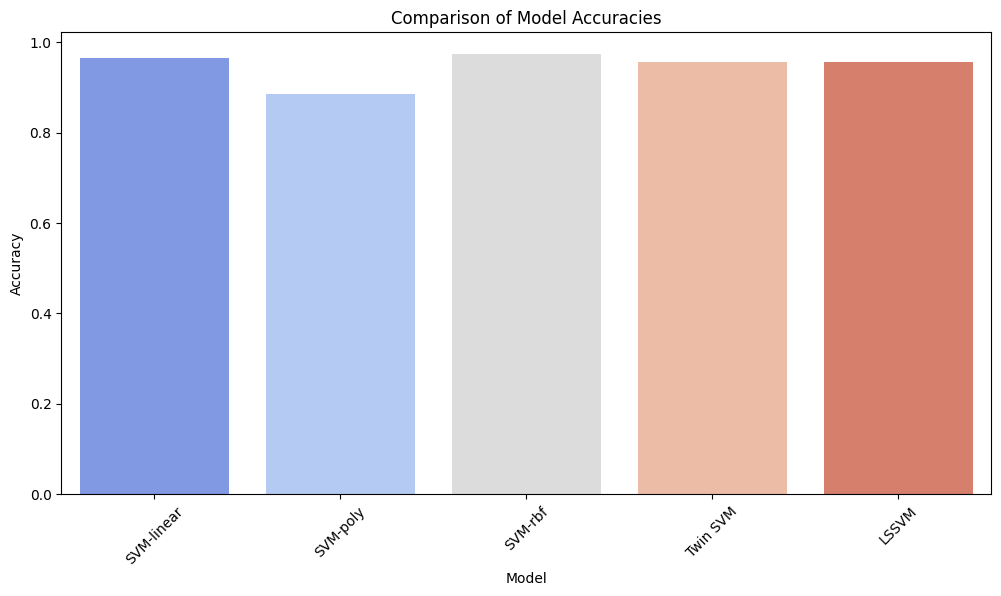

<ipython-input-37-bdc0314496f8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=results_df, palette='coolwarm')


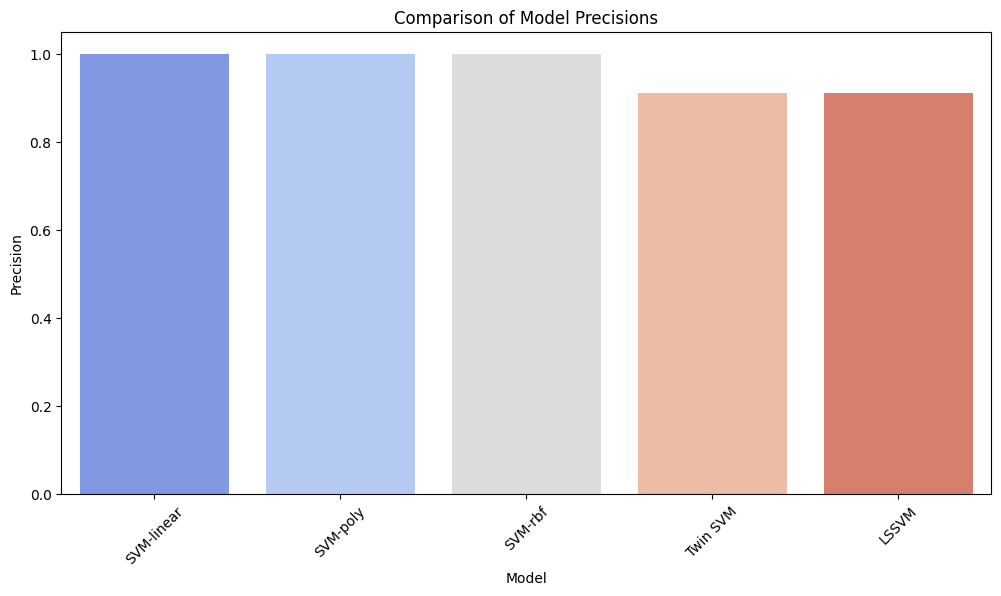

<ipython-input-37-bdc0314496f8>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=results_df, palette='coolwarm')


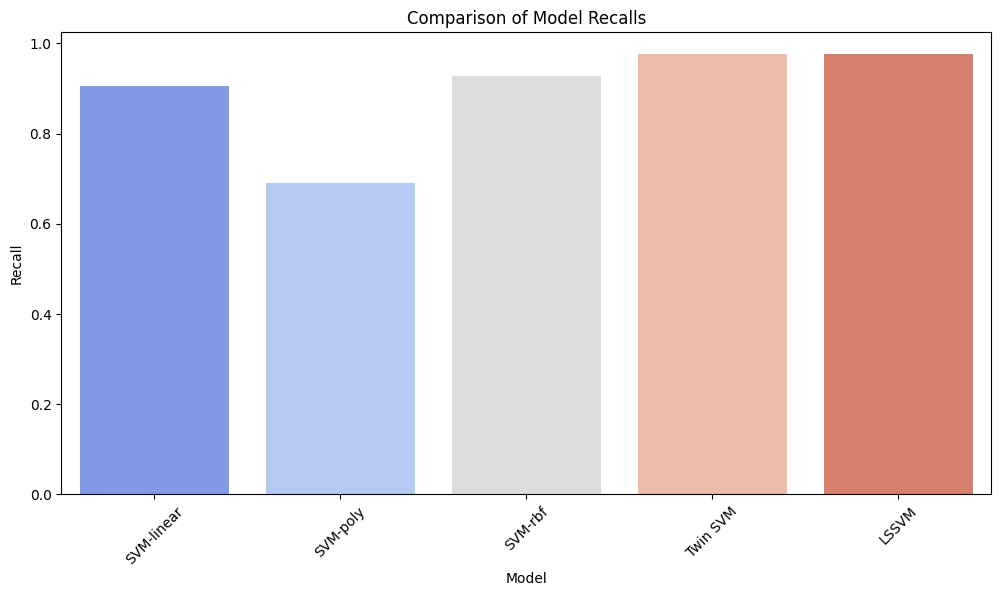

<ipython-input-37-bdc0314496f8>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-score', data=results_df, palette='coolwarm')


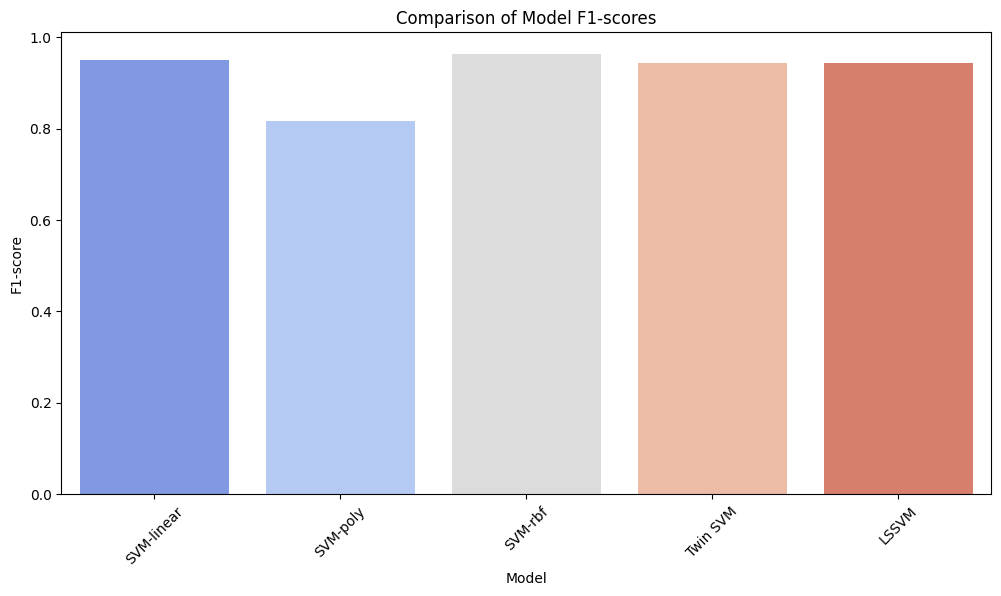

In [ ]:
# 📊 Visualizations 📊
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparison of Model Accuracies')
plt.show()

# 📊 Visualizations 📊
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Precision', data=results_df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparison of Model Precisions')
plt.show()

# 📊 Visualizations 📊
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Recall', data=results_df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparison of Model Recalls')
plt.show()

# 📊 Visualizations 📊
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='F1-score', data=results_df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparison of Model F1-scores')
plt.show()


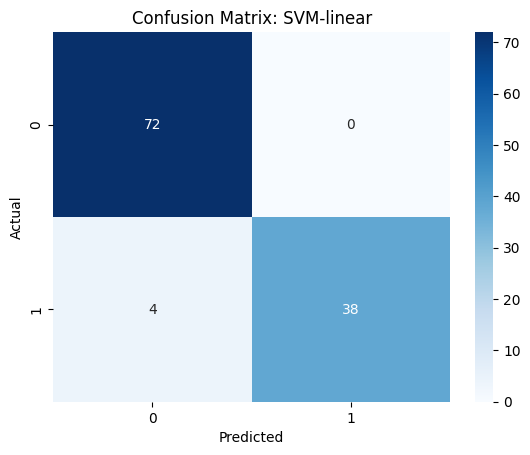

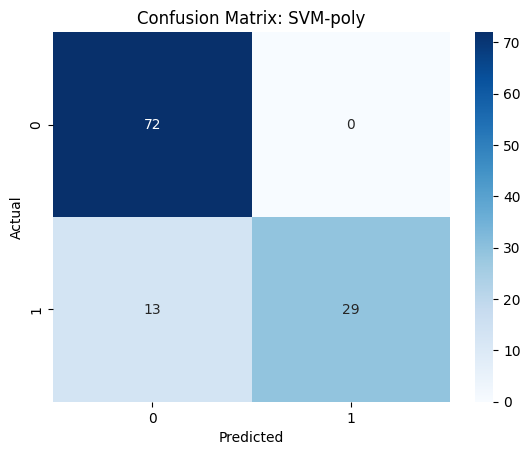

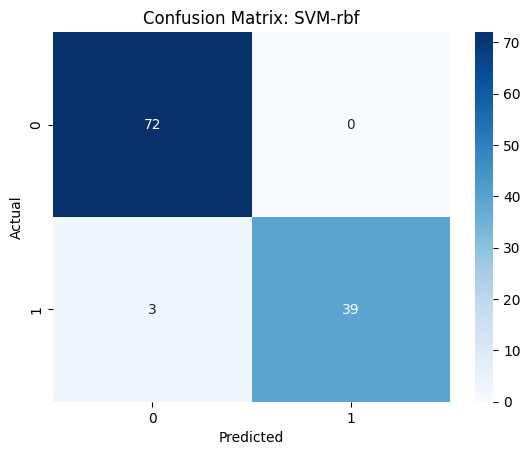

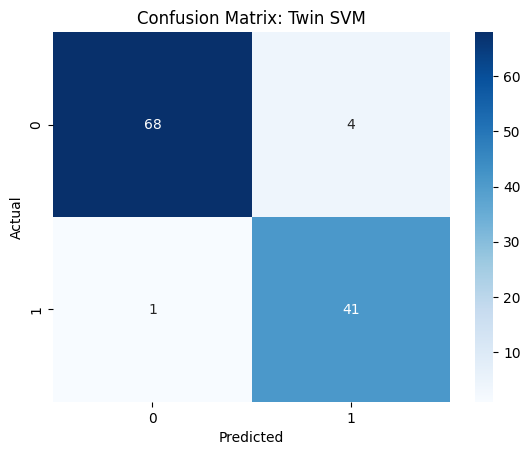

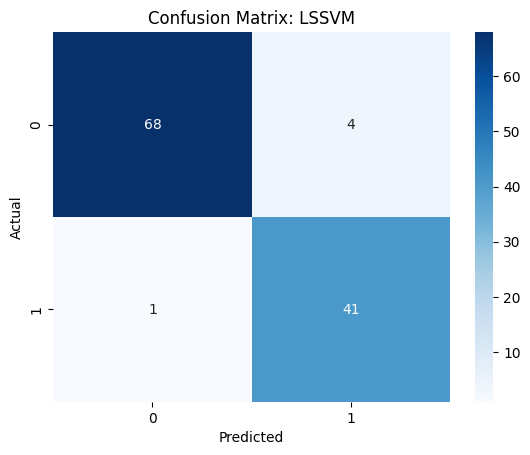

In [ ]:
# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

for model, preds in {**svm_preds}.items():
    plot_confusion_matrix(y_test, preds, model)


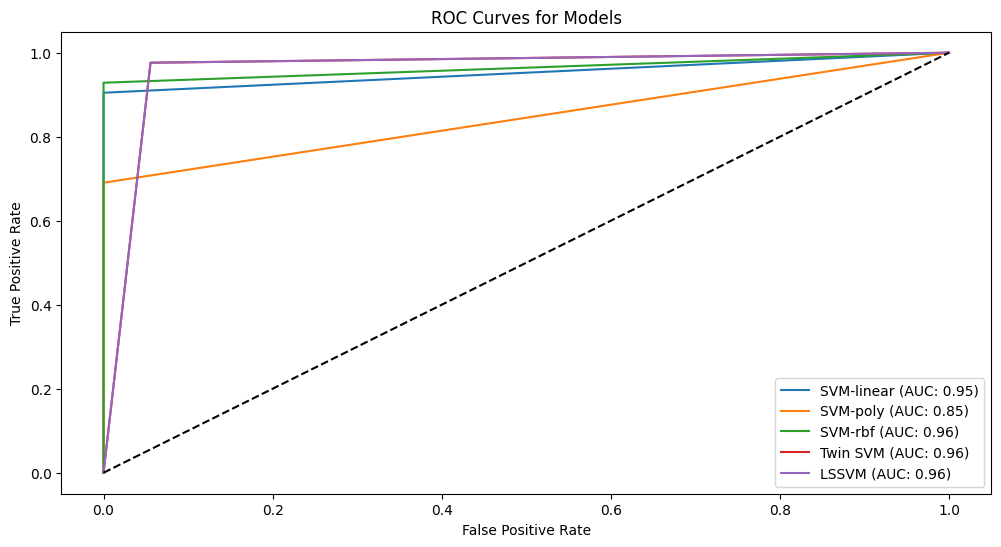

In [ ]:
# ROC Curves
plt.figure(figsize=(12,6))
for model, preds in {**svm_preds}.items():
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr, label=f"{model} (AUC: {auc(fpr, tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend()
plt.savefig('ROC_breast-cancer.png') # To save the figure
plt.show()

# Heatmaps for SVMs feature importance

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Tabular_data/breast_cancer_wisconsin_diagnostic.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

In [ ]:

X_column = df.iloc[:, :-1]
feature =  X_column.columns.tolist()
feature

['radius1',
 'texture1',
 'perimeter1',
 'area1',
 'smoothness1',
 'compactness1',
 'concavity1',
 'concave_points1',
 'symmetry1',
 'fractal_dimension1',
 'radius2',
 'texture2',
 'perimeter2',
 'area2',
 'smoothness2',
 'compactness2',
 'concavity2',
 'concave_points2',
 'symmetry2',
 'fractal_dimension2',
 'radius3',
 'texture3',
 'perimeter3',
 'area3',
 'smoothness3',
 'compactness3',
 'concavity3',
 'concave_points3',
 'symmetry3',
 'fractal_dimension3']

Permutation Feature importance for LSSVM and Twin SVM

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class TwinSVMWrapper:
    def fit(self, X, y):
        # Exemple de fitting : simple projection linéaire
        self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
        return self

    def predict(self, X):
        y_pred = np.sign(X @ self.w)
        return ((y_pred + 1) // 2).astype(int)

    def score(self, X, y):  # ← Méthode attendue par permutation_importance
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

class LSSVMWrapper(BaseEstimator):
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n = X.shape[0]
        K = X @ X.T + np.eye(n)
        self.alpha = np.linalg.solve(K, y)
        return self

    def predict(self, X):
        y_pred = np.sign(X @ self.X_train.T @ self.alpha)
        return ((y_pred + 1) // 2).astype(int)  # Convert {-1,1} to {0,1}

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


In [ ]:
from sklearn.inspection import permutation_importance

# Linear SVM importance
svm_linear = SVC(kernel='linear', random_state=42, probability=True)
svm_linear.fit(X_train, y_train)
importance_linear = np.abs(svm_linear.coef_).flatten()
#plot_feature_importance_heatmap(importance_linear, feature, "SVM - Linear")


# RBF SVM permutation importance
svm_rbf = SVC(kernel='rbf', random_state=42, probability=True)
svm_rbf.fit(X_train, y_train)
result_rbf = permutation_importance(svm_rbf, X_test, y_test, n_repeats=10, random_state=42)
importance_rbf = result_rbf.importances_mean
#plot_feature_importance_heatmap(importance_rbf, feature, "SVM - RBF")


# RBF SVM permutation importance
svm_poly = SVC(kernel='poly', random_state=42, probability=True)
svm_poly.fit(X_train, y_train)
result_poly = permutation_importance(svm_poly, X_test, y_test, n_repeats=10, random_state=42)
importance_poly = result_poly.importances_mean
#plot_feature_importance_heatmap(importance_poly, feature, "SVM - Poly")

# Twin SVM
twin_model = TwinSVMWrapper().fit(X_train, y_train)
result_twin = permutation_importance(twin_model, X_test, y_test, n_repeats=10, random_state=42)
importance_twin = result_twin.importances_mean

# LSSVM
lssvm_model = LSSVMWrapper().fit(X_train, y_train)
result_lssvm = permutation_importance(lssvm_model, X_test, y_test, n_repeats=10, random_state=42)
importance_lssvm = result_lssvm.importances_mean


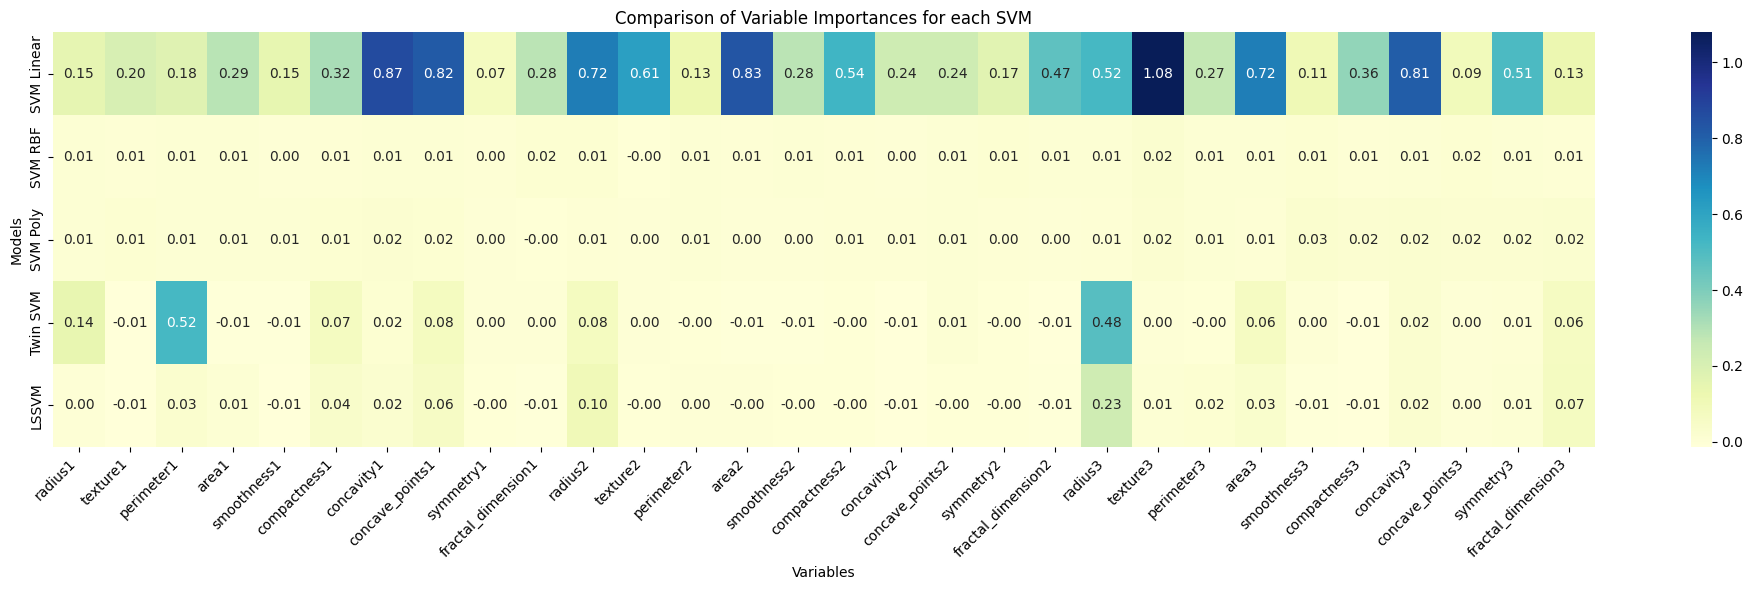

In [ ]:

# Combinaison des importances
importance_matrix = pd.DataFrame([
    importance_linear,
    importance_rbf,
    importance_poly,
    importance_twin,
    importance_lssvm
], index=['SVM Linear', 'SVM RBF', 'SVM Poly', 'Twin SVM', 'LSSVM'], columns=feature)

# Affichage de la heatmap comparative
plt.figure(figsize=(20, 6))
sns.heatmap(importance_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Comparison of Variable Importances for each SVM")
plt.xlabel("Variables")
plt.ylabel("Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance_comparison_Breast_cancer.png') # To save the figure
plt.show()


In [ ]:
class TwinSVMWrapper:
    def fit(self, X, y):
        self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
        return self

    def predict(self, X):
        return ((np.sign(X @ self.w) + 1) // 2).astype(int)

    def decision_function(self, X):
        return X @ self.w  # Score brut

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


class LSSVMWrapper:
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n = X.shape[0]
        K = X @ X.T + np.eye(n)
        self.alpha = np.linalg.solve(K, y)
        return self

    def predict(self, X):
        y_score = X @ self.X_train.T @ self.alpha
        return ((np.sign(y_score) + 1) // 2).astype(int)

    def decision_function(self, X):
        return X @ self.X_train.T @ self.alpha  # Score brut

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


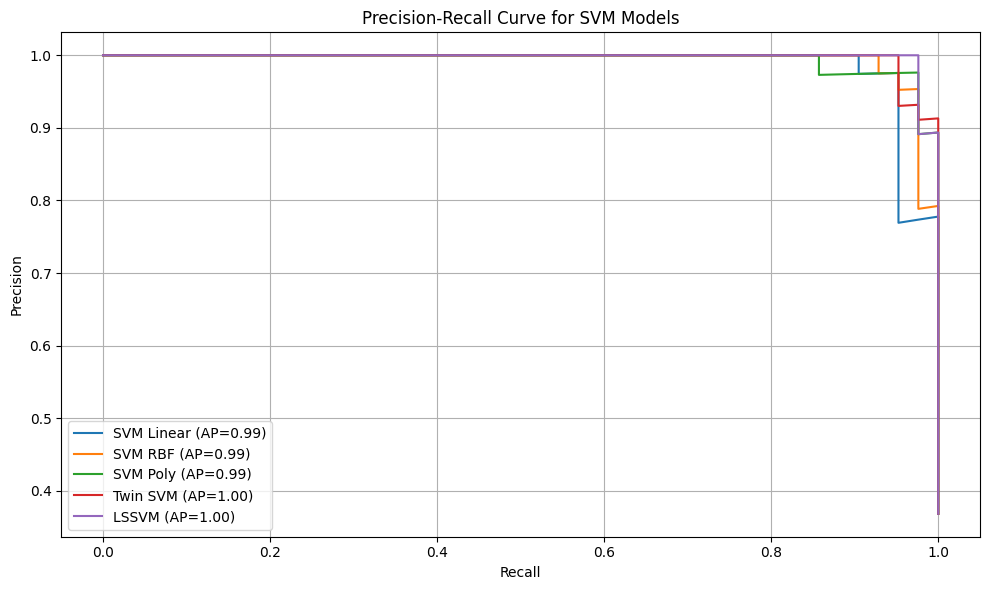

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Modèles à tester
models = {
    "SVM Linear": SVC(kernel='linear', probability=True, random_state=42),
    "SVM RBF": SVC(kernel='rbf', probability=True, random_state=42),
    "SVM Poly": SVC(kernel='poly', probability=True, random_state=42),
    "Twin SVM": TwinSVMWrapper(),
    "LSSVM": LSSVMWrapper()
}

plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train, y_train)

    # Pour SVC classiques → predict_proba
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    # Sinon, utilise la decision_function personnalisée
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError(f"{name} does not support scoring.")

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for SVM Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('PR_curve_breast-cancer.png') # To save the figure
plt.show()


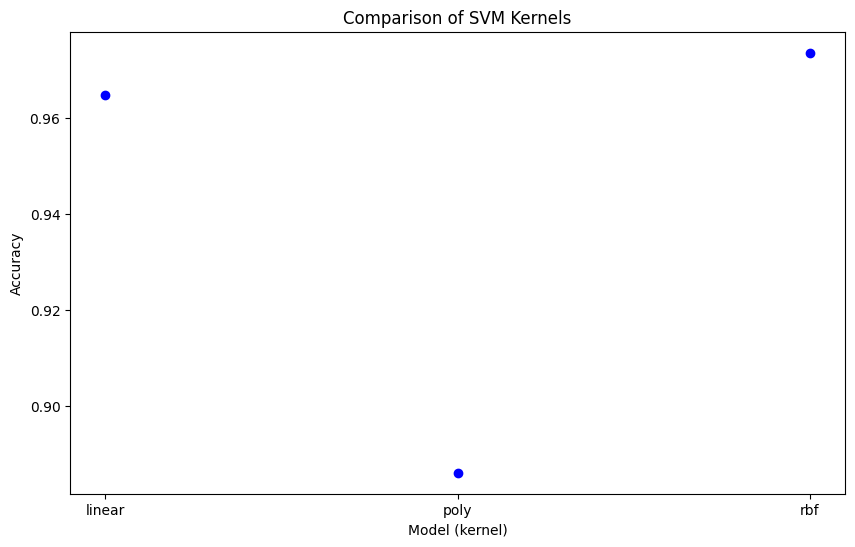

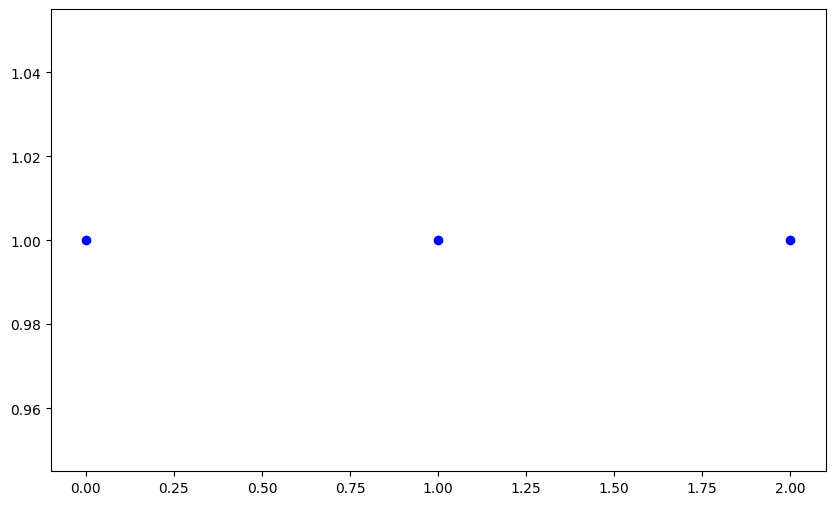

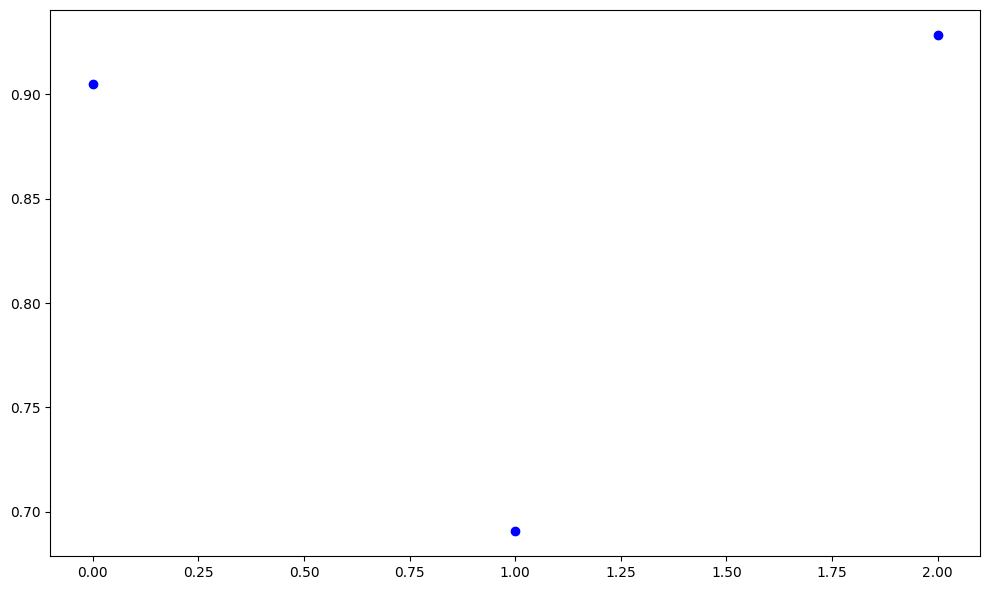

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
train_times = []
accuracies = []
precisions = []
recalls = []

for kernel in svm_kernels:
    clf = SVC(kernel=kernel)

    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()

    train_time = end - start
    acc = accuracy_score(y_test, clf.predict(X_test))


    pre = precision_score(y_test, clf.predict(X_test), zero_division=0)
    re = recall_score(y_test, clf.predict(X_test), zero_division=0)

    train_times.append(train_time)
    accuracies.append(acc)
    precisions.append(pre)
    recalls.append(re)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111)

fig2 = plt.figure(figsize=(10, 6))
ax2 = fig2.add_subplot(111)

xs = np.arange(len(svm_kernels))  # modèle index
yac = accuracies
ypre = precisions
yre = recalls
zs = train_times


ax.scatter(xs, yac, c='b', marker='o')
ax1.scatter(xs, ypre, c='b', marker='o')
ax2.scatter(xs, yre, c='b', marker='o')

ax.set_xticks(xs)
ax.set_xticklabels(svm_kernels)
ax.set_xlabel('Model (kernel)')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of SVM Kernels')
# plt.savefig('svm_comparison.png') # To save the figure
plt.tight_layout()
plt.show()

ax1.set_xticks(xs)
ax1.set_xticklabels(svm_kernels)
ax1.set_xlabel('Model (kernel)')
ax1.set_ylabel('Precision')
ax1.set_title('Comparison of SVM Kernels')
plt.tight_layout()
plt.show()

ax2.set_xticks(xs)
ax2.set_xticklabels(svm_kernels)
ax2.set_xlabel('Model (kernel)')
ax2.set_ylabel('Recall')
ax2.set_title('Comparison of SVM Kernels')
plt.tight_layout()
plt.show()

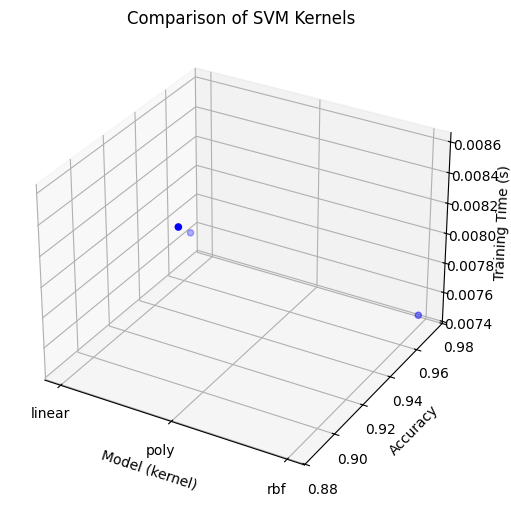

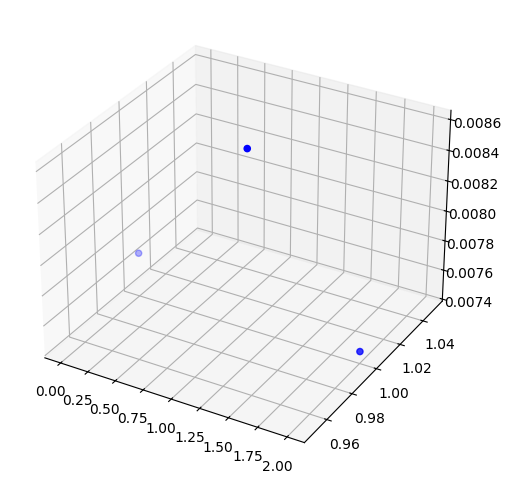

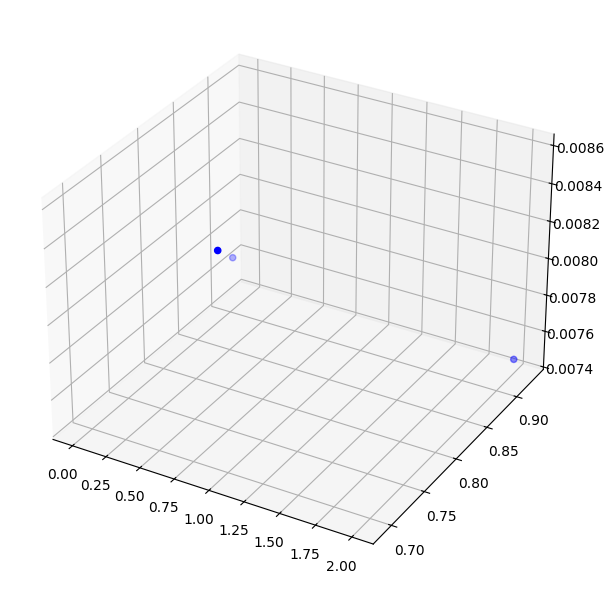

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

'\nfor k in svm_kernels:\n    svm = SVC(kernel=k)\n    scores = cross_val  '

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111, projection='3d')

fig2 = plt.figure(figsize=(10, 6))
ax2 = fig2.add_subplot(111, projection='3d')

xs = np.arange(len(svm_kernels))  # modèle index
yac = accuracies
ypre = precisions
yre = recalls
zs = train_times

ax.scatter(xs, yac, zs, c='b', marker='o')
ax1.scatter(xs, ypre, zs, c='b', marker='o')
ax2.scatter(xs, yre, zs, c='b', marker='o')

ax.set_xticks(xs)
ax.set_xticklabels(svm_kernels)
ax.set_xlabel('Model (kernel)')
ax.set_ylabel('Accuracy')
ax.set_zlabel('Training Time (s)')
ax.set_title('Comparison of SVM Kernels')
plt.tight_layout()
plt.show()

ax1.set_xticks(xs)
ax1.set_xticklabels(svm_kernels)
ax1.set_xlabel('Model (kernel)')
ax1.set_ylabel('Precision')
ax1.set_zlabel('Training Time (s)')
ax1.set_title('Comparison of SVM Kernels')
plt.tight_layout()
plt.show()

ax2.set_xticks(xs)
ax2.set_xticklabels(svm_kernels)
ax2.set_xlabel('Model (kernel)')
ax2.set_ylabel('Recall')
ax2.set_zlabel('Training Time (s)')
ax2.set_title('Comparison of SVM Kernels')
plt.tight_layout()
plt.show()

"""
for k in svm_kernels:
    svm = SVC(kernel=k)
    scores = cross_val  """

In [ ]:
def cross_validate_custom_model(model_func, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    for train_idx, test_idx in skf.split(X_scaled, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Convert labels for custom models expecting {-1, 1}
        y_train_signed = 2 * y_train - 1  # From {0, 1} to {-1, 1}

        start_time = time.time()
        cpu_usage_start = psutil.cpu_percent()
        memory_usage_start = psutil.virtual_memory().used / (1024 ** 2)

        y_pred = model_func(X_train, y_train_signed, X_test)

        end_time = time.time()
        cpu_usage_end = psutil.cpu_percent()
        memory_usage_end = psutil.virtual_memory().used / (1024 ** 2)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        train_time = end_time - start_time
        cpu = cpu_usage_end - cpu_usage_start
        mem = memory_usage_end - memory_usage_start

        metrics.append([acc, prec, rec, f1, train_time, cpu, mem])

    # Compute mean of metrics across folds
    mean_metrics = np.mean(metrics, axis=0)
    return mean_metrics

# Twin SVM CV
twin_svm_cv = cross_validate_custom_model(twin_svm, X_scaled, y)
svm_results.append(['Twin SVM (CV)'] + list(twin_svm_cv))

# LSSVM CV
lssvm_cv = cross_validate_custom_model(lssvm, X_scaled, y)
svm_results.append(['LSSVM (CV)'] + list(lssvm_cv))

labels = ["Accuracy", "Precision", "Recall", "F1-score", "Train Time (s)", "CPU Usage", "Memory Usage (MB)"]

print("🔹 Twin SVM Cross-Validation Results:")
for label, val in zip(labels, twin_svm_cv):
    print(f"{label}: {val:.4f}")

print("\n🔹 LSSVM Cross-Validation Results:")
for label, val in zip(labels, lssvm_cv):
    print(f"{label}: {val:.4f}")

🔹 Twin SVM Cross-Validation Results:
Accuracy: 0.9561
Precision: 0.9580
Recall: 0.9561
F1-score: 0.9564
Train Time (s): 0.0012
CPU Usage: -59.6600
Memory Usage (MB): 0.1477

🔹 LSSVM Cross-Validation Results:
Accuracy: 0.9561
Precision: 0.9578
Recall: 0.9561
F1-score: 0.9563
Train Time (s): 0.0576
CPU Usage: 0.0000
Memory Usage (MB): 1.7227


In [ ]:
# Cross-Validation
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("value of cv:", cv)
for kernel in svm_kernels:
  model_SVM = SVC(kernel=kernel, random_state=42, probability=True)

  grid = GridSearchCV(model_SVM, param_grid, cv=cv)
  grid.fit(X_train, y_train)

  print("Best parameters:", grid.best_params_)
  print("Best score:", grid.best_score_)
  print("Best estimation:", grid.best_estimator_)

  # Evaluation
  test_score = grid.score(X_test, y_test)
  print("Test accuracy:", test_score)

  scores_grid = cross_val_score(grid.best_estimator_, X_train, y_train, cv=cv)
  print("Mean Score:", scores_grid.mean())

  scores = cross_val_score(model_SVM, X_train, y_train, cv=cv)
  print(f"Cross-validation scores for {kernel} kernel: {scores.mean()}")
  print("--------------------------------------------------------------")

value of cv: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9758241758241759
Best estimation: SVC(C=10, probability=True, random_state=42)
Test accuracy: 0.9736842105263158
Mean Score: 0.9758241758241759
Cross-validation scores for linear kernel: 0.9648351648351647
--------------------------------------------------------------
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9758241758241759
Best estimation: SVC(C=10, probability=True, random_state=42)
Test accuracy: 0.9736842105263158
Mean Score: 0.9758241758241759
Cross-validation scores for poly kernel: 0.8989010989010989
--------------------------------------------------------------
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.9758241758241759
Best estimation: SVC(C=10, probability=True, random_state=42)
Test accuracy: 0.9736842105263158
Mean Score: 0.9758241758241759
Cross-validation sco

In [ ]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import shapiro, ttest_rel, wilcoxon
import numpy as np
from numpy.linalg import inv, norm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from qpsolvers import solve_qp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# 🔹 Function to load datasets easily 🔹
def load_dataset(dataset_name="breast_cancer_wisconsin_diagnostic"):
    if dataset_name == "breast_cancer_wisconsin_diagnostic":
        df = pd.read_csv("/content/drive/MyDrive/Tabular_data/breast_cancer_wisconsin_diagnostic.csv", header=None)
        # 🐛 The first row was being treated as data, causing the error.
        #    We skip the first row using 'df[1:]' to select from row index 1 onwards.
        # Convert X and y to numeric type
        X = df.iloc[1:, :-1].values.astype(float) # Convert features to float
        y = pd.to_numeric(df.iloc[1:, -1]).astype(int).values # Convert y to numeric type and then to numpy array
        return X, y
    elif dataset_name == "heart_disease":
       df = pd.read_csv("/content/drive/MyDrive/Tabular_data/heart_disease.csv")
       df.dropna(inplace=True) # Drop rows with any missing values
       X = df.iloc[:, :-1].values.astype(float) # Convert features to float
       y = df.iloc[:, -1].values # y is already numeric in this dataset
       return X, y
    else:
        raise ValueError(f"Dataset {dataset_name} not supported!")

# 🔹 Select dataset 🔹
dataset_name = "breast_cancer_wisconsin_diagnostic"  # Set back to the dataset causing the original error
X, y = load_dataset(dataset_name)

# 🔹 Standardize the data 🔹
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Define models 🔹
svm_kernels = ['linear', 'poly', 'rbf']
svm_models = [SVC(kernel=k, probability=True, random_state=42) for k in svm_kernels]


# 🔹 Twin Support Vector Machines (TWSVM) 🔹
# A more complete implementation of Linear Twin SVM using qpsolvers

def twin_svm(X_train, y_train, X_test, C1=1.0, C2=1.0):
    """
    Linear Twin Support Vector Machine Classifier.
    Assumes binary classification with labels {-1, 1}.

    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels {-1, 1}.
        X_test (np.ndarray): Testing features.
        C1 (float): Regularization parameter for the first problem.
        C2 (float): Regularization parameter for the second problem.

    Returns:
        np.ndarray: Predicted labels {0, 1}.
    """
    # Ensure y_train is in the format {-1, 1}
    unique_labels = np.unique(y_train)
    if not (np.array_equal(unique_labels, [-1, 1]) or np.array_equal(unique_labels, [1, -1])):
         raise ValueError("Twin SVM requires y_train labels to be -1 or 1.")

    # Split data based on class labels
    X1 = X_train[y_train == 1]
    X2 = X_train[y_train == -1]

    n1 = X1.shape[0]
    n2 = X2.shape[0]
    n_features = X_train.shape[1]

    # Add bias term (constant 1) to feature matrices
    H1 = np.hstack((X1, np.ones((n1, 1))))
    H2 = np.hstack((X2, np.ones((n2, 1))))

    # --- Problem 1: Find plane for class 1 (minimize distance to X1, maximize distance to X2) ---
    # Dual problem for the first plane (for class 1):
    # Variables are alpha of size n1
    P1 = H1 @ H1.T # P matrix for the QP problem
    q1 = -np.ones(n1) # q vector for the QP problem

    # Constraints G @ alpha <= h:
    # H2 @ (H1.T @ alpha) >= 0  => -H2 @ H1.T @ alpha <= 0
    # alpha >= 0                => -I @ alpha <= 0
    # alpha <= C1               => I @ alpha <= C1
    G1 = np.vstack([-H2 @ H1.T, -np.eye(n1), np.eye(n1)])
    h1 = np.hstack([np.zeros(n2), np.zeros(n1), C1 * np.ones(n1)])

    try:
        # Convert to double precision if not already (cvxopt often prefers this)
        P1_qp = P1.astype(float)
        q1_qp = q1.astype(float)
        G1_qp = G1.astype(float)
        h1_qp = h1.astype(float)

        # Add a small regularization term to P to ensure positive definiteness
        P1_qp = P1_qp + 1e-8 * np.eye(P1_qp.shape[0]) # This can help with numerical stability

        v1 = solve_qp(P1_qp, q1_qp, G1_qp, h1_qp, solver="cvxopt")
    except ValueError as e:
         print(f"QP Problem 1 failed: {e}")
         # Handle failure - perhaps return a default or raise error
         return np.zeros(X_test.shape[0], dtype=int) # Return zeros for now
    except Exception as e:
         print(f"An unexpected error occurred during QP Problem 1: {e}")
         return np.zeros(X_test.shape[0], dtype=int) # Return zeros for now


    if v1 is None: # solve_qp returns None if no solution found
        print("QP Problem 1 did not find a solution.")
        return np.zeros(X_test.shape[0], dtype=int) # Return zeros for now

    v1 = np.array(v1).flatten() # Convert from matrix/column vector to 1D numpy array

    # Calculate w1 and b1 from v1
    # w1 (weights + bias) = H1.T @ v1
    w1_primal = H1.T @ v1 # This gives [w; b] for the first plane

    # --- Problem 2: Find plane for class -1 (minimize distance to X2, maximize distance to X1) ---
    # Dual problem for the second plane (for class -1):
    # Variables are beta of size n2
    P2 = H2 @ H2.T # P matrix for the QP problem
    q2 = -np.ones(n2) # q vector for the QP problem

    # Constraints G @ beta <= h:
    # H1 @ (H2.T @ beta) >= 0 => -H1 @ H2.T @ beta <= 0
    # beta >= 0              => -I @ beta <= 0
    # beta <= C2             => I @ beta <= C2
    G2 = np.vstack([-H1 @ H2.T, -np.eye(n2), np.eye(n2)])
    h2 = np.hstack([np.zeros(n1), np.zeros(n2), C2 * np.ones(n2)])


    try:
        P2_qp = P2.astype(float)
        q2_qp = q2.astype(float)
        G2_qp = G2.astype(float)
        h2_qp = h2.astype(float)

        # Add a small regularization term to P to ensure positive definiteness
        P2_qp = P2_qp + 1e-8 * np.eye(P2_qp.shape[0]) # This can help with numerical stability

        v2 = solve_qp(P2_qp, q2_qp, G2_qp, h2_qp, solver="cvxopt")
    except ValueError as e:
        print(f"QP Problem 2 failed: {e}")
        return np.zeros(X_test.shape[0], dtype=int)
    except Exception as e:
        print(f"An unexpected error occurred during QP Problem 2: {e}")
        return np.zeros(X_test.shape[0], dtype=int)

    if v2 is None:
         print("QP Problem 2 did not find a solution.")
         return np.zeros(X_test.shape[0], dtype=int)

    v2 = np.array(v2).flatten()

    # Calculate w2 and b2 from v2
    w2_primal = H2.T @ v2 # This gives [w; b] for the second plane

    # Add bias term to test data for projection
    X_test_ext = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

    # Signed distance to the first plane: w1_primal.T * [x_test; 1]
    distance1 = X_test_ext @ w1_primal

    # Signed distance to the second plane: w2_primal.T * [x_test; 1]
    distance2 = X_test_ext @ w2_primal

    # Use signed distances for prediction (predict class 1 if closer to plane 1)
    # The original paper often predicts based on which distance is *smaller*
    # for the class it represents. For plane 1 (class 1), if distance1 < distance2
    # predict class 1. Otherwise predict class -1.
    norm_w1 = norm(w1_primal[0:-1]) + 1e-8 # Add epsilon for stability
    norm_w2 = norm(w2_primal[0:-1]) + 1e-8 # Add epsilon for stability

    # Distances to the planes (absolute value)
    distances1 = np.abs(distance1) / norm_w1
    distances2 = np.abs(distance2) / norm_w2

    # Predict 1 if distance to plane 1 is less than distance to plane 2, else -1
    y_pred_signed = np.where(distances1 < distances2, 1, -1)

    # Convert back to {0, 1} for compatibility with metrics
    return (y_pred_signed + 1) // 2


# 🔹 Least Squares SVM (LSSVM) 🔹
# Note: This LSSVM implementation seems to be for regression or a simplified binary case.
# A typical binary classification LSSVM would involve solving a system related to KKT conditions.
# For the purpose of fixing the error and matching the user's implementation:
# The original LSSVM function in the notebook expects {-1, 1} labels internally for the matrix inversion.
# It calculates alpha using np.linalg.solve(K, y_train) where y_train is the input.
# It then predicts using np.sign(X_test @ X_train.T @ alpha), which implies alpha is expected to work with {-1, 1}.
# Finally, it converts the signed prediction back to {0, 1}.
# So, similar to twin_svm, the y_train input to lssvm within the statistical testing loop should be {-1, 1}.

def lssvm(X_train, y_train, X_test):
    """
    Simplified Linear Least Squares Support Vector Machine Classifier.
    Assumes binary classification with labels {-1, 1}.

    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels {-1, 1}.
        X_test (np.ndarray): Testing features.

    Returns:
        np.ndarray: Predicted labels {0, 1}.
    """
    # Add a small regularization term to K for numerical stability
    K = X_train @ X_train.T + np.eye(len(X_train)) * 1e-6
    alpha = np.linalg.solve(K, y_train)
    y_pred = np.sign(X_test @ X_train.T @ alpha)
    # Convert {-1,1} to {0,1} for compatibility with metrics
    return (y_pred + 1) // 2


# 🔹 Cross-validation 🔹
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = {name: [] for name in ['SVM-linear', 'SVM-poly', 'SVM-rbf', 'Twin SVM', 'LSSVM']}

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx] # Use scaled data
    y_train, y_test = y[train_idx], y[test_idx]

    # Convert y_train to {-1, 1} for Twin SVM and LSSVM
    y_train_signed = 2 * y_train - 1

    print(f"--- Fold {fold_idx + 1} ---") # Optional: track folds
    print(f"y_train unique values before conversion: {np.unique(y_train)}")
    print(f"y_train unique values after conversion (for Twin SVM/LSSVM): {np.unique(y_train_signed)}")
    print(f"y_test unique values: {np.unique(y_test)}")

    for kernel, model in zip(svm_kernels, svm_models):
        # SVM models (SVC) handle {0, 1} labels directly
        # Reset the model for each fold to avoid retaining training state
        model = SVC(kernel=kernel, probability=True, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        f1 = f1_score(y_test, preds, zero_division=0)
        f1_scores[f'SVM-{kernel}'].append(f1)
        print(f"  SVM-{kernel} F1: {f1:.4f}")

    # Pass the {-1, 1} labels to twin_svm and lssvm
    # Ensure Twin SVM and LSSVM are using the scaled data X_train
    preds_twin = twin_svm(X_train, y_train_signed, X_test)
    f1_twin = f1_score(y_test, preds_twin, zero_division=0)
    f1_scores['Twin SVM'].append(f1_twin)
    print(f"  Twin SVM F1: {f1_twin:.4f}")

    # Ensure LSSVM is using the scaled data X_train
    preds_lssvm = lssvm(X_train, y_train_signed, X_test)
    f1_lssvm = f1_score(y_test, preds_lssvm, zero_division=0)
    f1_scores['LSSVM'].append(f1_lssvm)
    print(f"  LSSVM F1: {f1_lssvm:.4f}")


# 🔹 Normality test (Shapiro) on differences 🔹
# Ensure both lists have the same number of elements before computing diff
if len(f1_scores['SVM-rbf']) == len(f1_scores['LSSVM']):
    diff = np.array(f1_scores['SVM-rbf']) - np.array(f1_scores['LSSVM'])
    # Shapiro test requires at least 3 samples.
    if len(diff) >= 3:
        try:
            shapiro_test = shapiro(diff)
            print("\nShapiro-Wilk Test:", shapiro_test)
            stat, p_value = shapiro_test
            print(f"Shapiro Statistic = {stat:.4f}, p-value = {p_value:.4f}")
            if p_value > 0.05:
                print("✅ Les différences suivent une loi normale (on peut utiliser le t-test).")
            else:
                print("❌ Les différences ne suivent pas une loi normale (préférer le test de Wilcoxon).")
        except ValueError as e:
             print(f"\nSkipping Shapiro-Wilk Test: {e}")
             shapiro_test = "N/A"
    else:
        print("\nSkipping Shapiro-Wilk Test: Need at least 3 folds.")
        shapiro_test = "N/A"

else:
    print("\nSkipping Shapiro-Wilk Test due to unequal number of folds.")
    shapiro_test = "N/A"


# 🔹 Paired t-test and Wilcoxon test 🔹
# Ensure both lists have the same number of elements before computing t-test/wilcoxon
if len(f1_scores['SVM-rbf']) == len(f1_scores['LSSVM']):
    # Need at least 2 folds for t-test/wilcoxon
    if len(f1_scores['SVM-rbf']) >= 2:
        try:
            # Paired t-test assumes normal distribution of differences
            t_test = ttest_rel(f1_scores['SVM-rbf'], f1_scores['LSSVM'])
            print("\nPaired t-test:", t_test)
            t_stat, p_value = t_test

            print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
            if p_value < 0.05:
                print("Différence significative entre les modèles.")
            else:
                print("Pas de différence significative.")
        except ValueError as e:
             print(f"\nSkipping Paired t-test: {e}")
             t_test = "N/A"

        try:
            # Wilcoxon signed-rank test is a non-parametric alternative
            wilcoxon_test = wilcoxon(f1_scores['SVM-rbf'], f1_scores['LSSVM'])
            print("\nWilcoxon test:", wilcoxon_test)
            stat, p = wilcoxon_test

            print(f"Wilcoxon statistic = {stat:.4f}, p-value = {p:.4f}")
            if p < 0.05:
                print("Différence significative entre les modèles.")
            else:
                print("Pas de différence significative.")
        except ValueError as e:
             print(f"\nSkipping Wilcoxon test: {e}")
             wilcoxon_test = "N/A"

    else:
        print("\nSkipping t-test and Wilcoxon test: Need at least 2 folds.")
        t_test = "N/A"
        wilcoxon_test = "N/A"

else:
    print("\nSkipping t-test and Wilcoxon test due to unequal number of folds.")
    t_test = "N/A"
    wilcoxon_test = "N/A"


# 🔹 Results 🔹
print("\nF1-scores:", f1_scores)
# Shapiro test, t-test, and Wilcoxon test results are printed above

--- Fold 1 ---
y_train unique values before conversion: [0 1]
y_train unique values after conversion (for Twin SVM/LSSVM): [-1  1]
y_test unique values: [0 1]
  SVM-linear F1: 0.9885
  SVM-poly F1: 0.9114
  SVM-rbf F1: 0.9885
  Twin SVM F1: 0.0408
  LSSVM F1: 0.9231
--- Fold 2 ---
y_train unique values before conversion: [0 1]
y_train unique values after conversion (for Twin SVM/LSSVM): [-1  1]
y_test unique values: [0 1]
  SVM-linear F1: 0.9286
  SVM-poly F1: 0.7714
  SVM-rbf F1: 0.9176
  Twin SVM F1: 0.0000
  LSSVM F1: 0.9767
--- Fold 3 ---
y_train unique values before conversion: [0 1]
y_train unique values after conversion (for Twin SVM/LSSVM): [-1  1]
y_test unique values: [0 1]
  SVM-linear F1: 0.9383
  SVM-poly F1: 0.8169
  SVM-rbf F1: 0.9630
  Twin SVM F1: 0.2883
  LSSVM F1: 0.8837
--- Fold 4 ---
y_train unique values before conversion: [0 1]
y_train unique values after conversion (for Twin SVM/LSSVM): [-1  1]
y_test unique values: [0 1]
  SVM-linear F1: 0.9882
  SVM-poly F1: 0

# Heart Disease
Method using: Drop rows with any missing values

In [ ]:

df = pd.read_csv("/content/drive/MyDrive/Tabular_data/heart_disease.csv")
df.head()

X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
print(np.unique(y))

[0 1 2 3 4]


In [ ]:
df.isna().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
values = pd.value_counts(y)

/tmp/ipython-input-5-900487234.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  values = pd.value_counts(y)


In [ ]:
values * 100 / len(y)

,count
0,54.125413
1,18.151815
2,11.881188
3,11.551155
4,4.290429


<Axes: ylabel='values'>

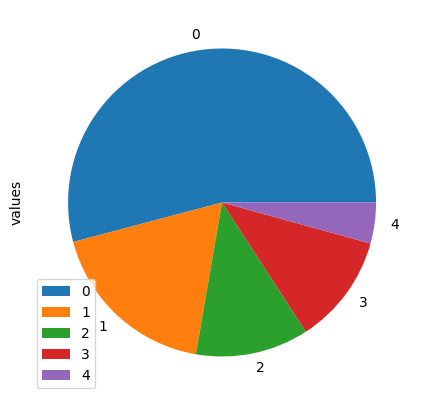

In [ ]:
pd.DataFrame({"y": np.unique(y), "values": values.to_list()}).plot(kind = "pie", y = "values", figsize = (5,5))


[0 1 2 3 4]


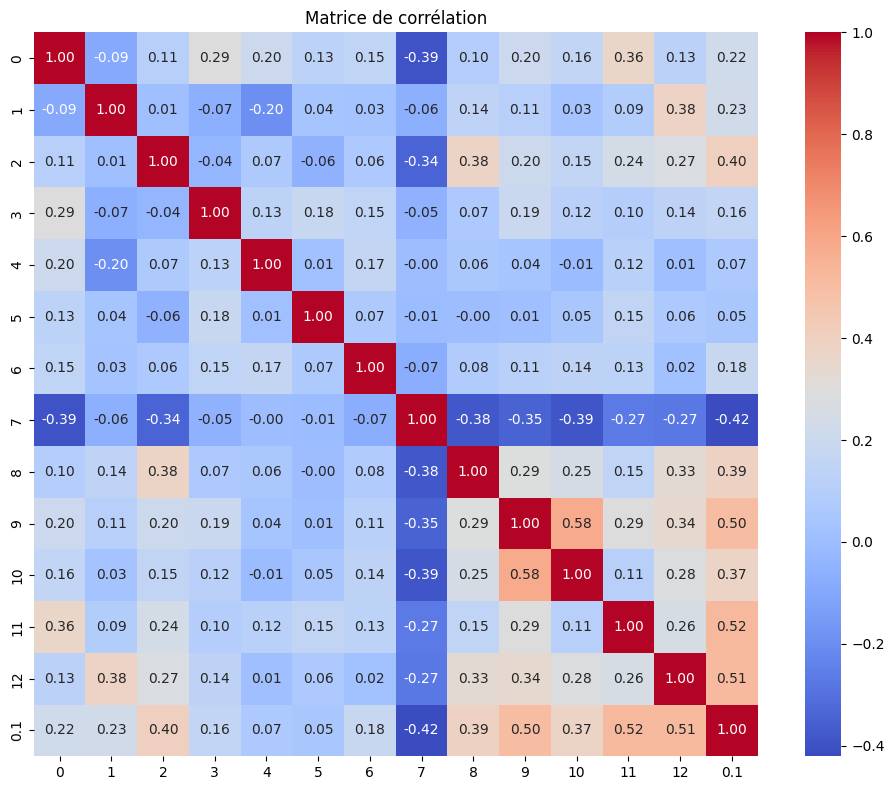

'\n# 🔹 Impute missing values using SimpleImputer 🔹\nimputer = SimpleImputer(strategy=\'mean\') # or strategy=\'median\', etc.\nX = imputer.fit_transform(X)\n\n\n# print(\'Original dataset shape %s\' % Counter(y))\n# Resampling\nsm = SMOTE(random_state=42)\nX, y = sm.fit_resample(X, y)\nprint(\'Resampled dataset shape %s\' % Counter(y))\n\nvalues = pd.value_counts(y)\npd.DataFrame({"y": np.unique(y), "values": values.to_list()}).plot(kind = "pie", y = "values", figsize = (5,5))\n'

In [ ]:
# 🔹 Function to load datasets easily 🔹
def load_dataset(dataset_name="breast_cancer_wisconsin_diagnostic"):
    if dataset_name == "breast_cancer_wisconsin_diagnostic":
        df = pd.read_csv("/content/drive/MyDrive/Tabular_data/breast_cancer_wisconsin_diagnostic.csv", header=None)
        # 🐛 The first row was being treated as data, causing the error.
        #    We skip the first row using 'df[1:]' to select from row index 1 onwards.
        X, y = df.iloc[1:, :-1].values, df.iloc[1:, -1].values
        # Convert y to numeric type
        y = pd.to_numeric(y).astype(int)
        return X, y
    elif dataset_name == "heart_disease":
       df = pd.read_csv("/content/drive/MyDrive/Tabular_data/heart_disease.csv")
       df.dropna(inplace=True) # Drop rows with any missing values
       X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
       return X, y
    else:
        raise ValueError(f"Dataset {dataset_name} not supported!")

# 🔹 Select dataset 🔹
# dataset_name = "breast_cancer_wisconsin_diagnostic"  # Change this to switch datasets
dataset_name = "heart_disease"
X, y = load_dataset(dataset_name)
print(np.unique(y))
df_breast_cancer = pd.concat([pd.DataFrame(X),pd.DataFrame(y)],axis=1)
df_breast_cancer.to_csv('heart_disease.csv', index=False)
data3 = pd.read_csv('heart_disease.csv')
# Calculer la matrice de corrélation
corr_matrix = data3.corr(numeric_only=True)  # Corrélation entre variables numériques

# Affichage avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

'''
# 🔹 Impute missing values using SimpleImputer 🔹
imputer = SimpleImputer(strategy='mean') # or strategy='median', etc.
X = imputer.fit_transform(X)


# print('Original dataset shape %s' % Counter(y))
# Resampling
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y))

values = pd.value_counts(y)
pd.DataFrame({"y": np.unique(y), "values": values.to_list()}).plot(kind = "pie", y = "values", figsize = (5,5))
'''

In [ ]:
classes = np.unique(y)
print(classes)

[0 1 2 3 4]



Comparison of Models:
        Model  Accuracy  Precision    Recall  F1-score  Training Time (s)  \
0  SVM-linear  0.633333   0.556439  0.633333  0.585114           0.030461   
1    SVM-poly  0.600000   0.432000  0.600000  0.502326           0.023575   
2     SVM-rbf  0.650000   0.551429  0.650000  0.591814           0.027326   
3    Twin SVM  0.583333   0.643790  0.583333  0.605035           0.001600   
4       LSSVM  0.583333   0.643790  0.583333  0.605035           0.010743   

   CPU Usage (%)  Memory Usage (MB)  
0           32.3                0.0  
1           -6.7                0.0  
2           50.0                0.0  
3          -50.0                0.0  
4           50.0                0.0  


/tmp/ipython-input-11-2330849221.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='coolwarm')


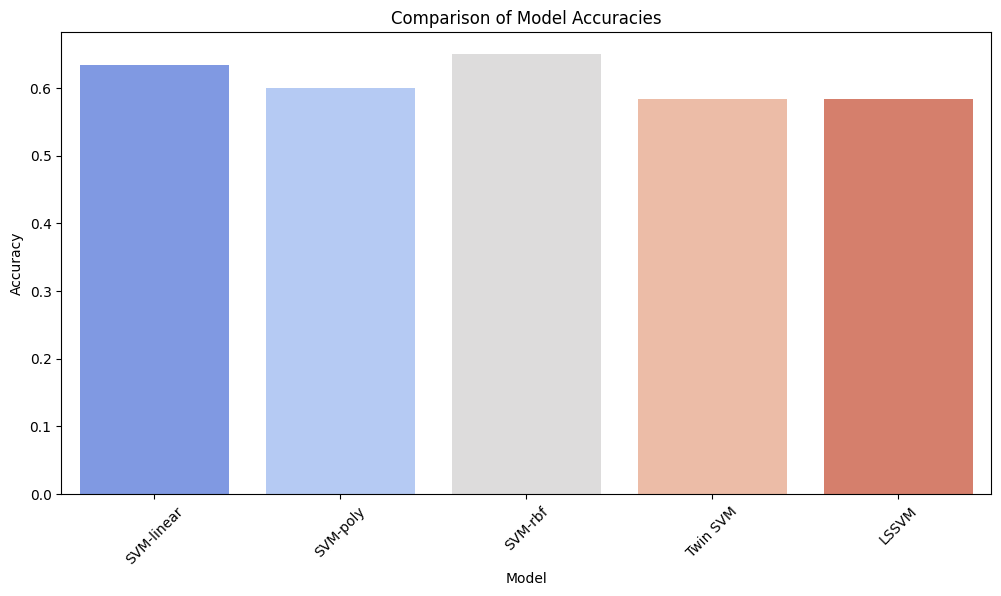

/tmp/ipython-input-11-2330849221.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=results_df, palette='coolwarm')


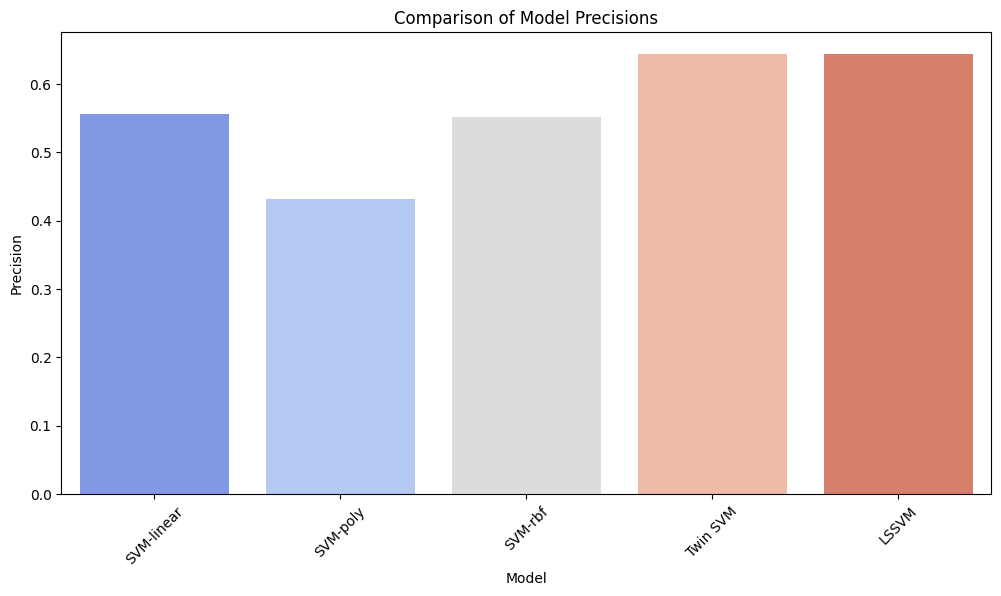

/tmp/ipython-input-11-2330849221.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=results_df, palette='coolwarm')


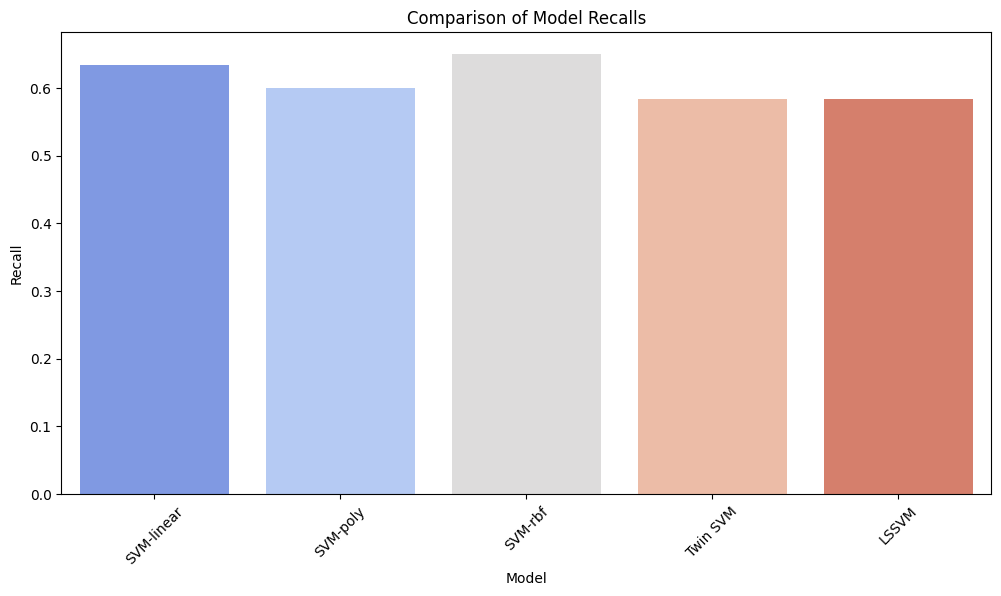

/tmp/ipython-input-11-2330849221.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-score', data=results_df, palette='coolwarm')


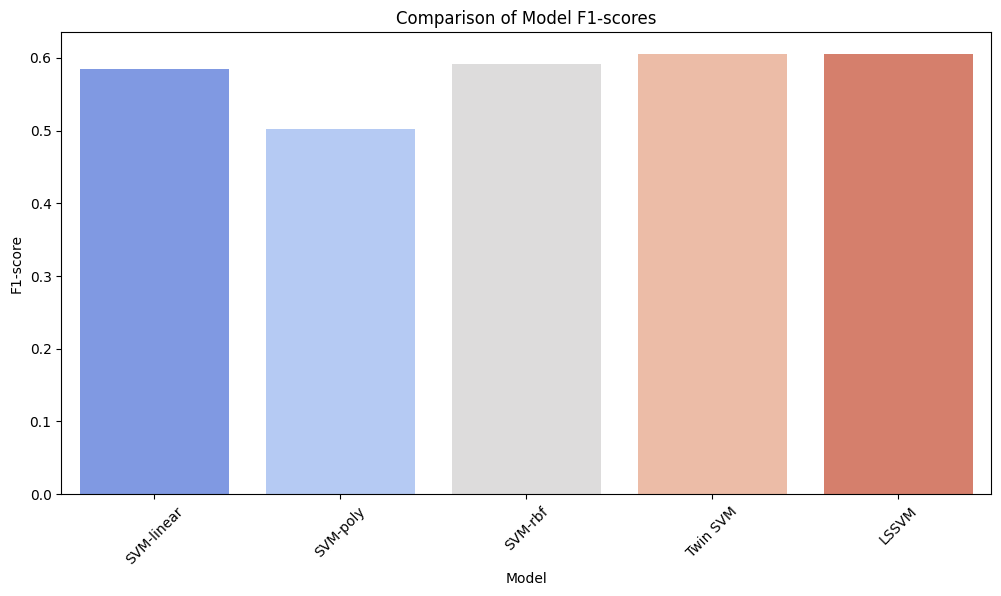

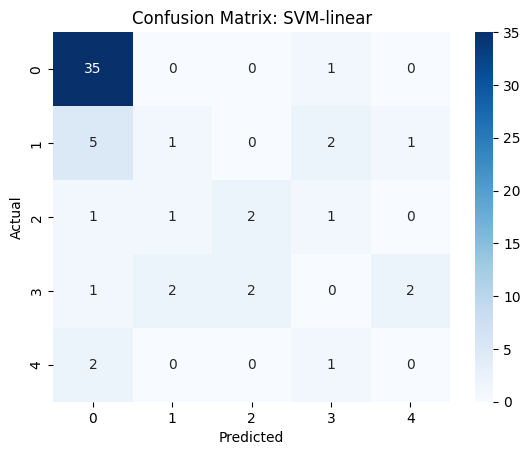

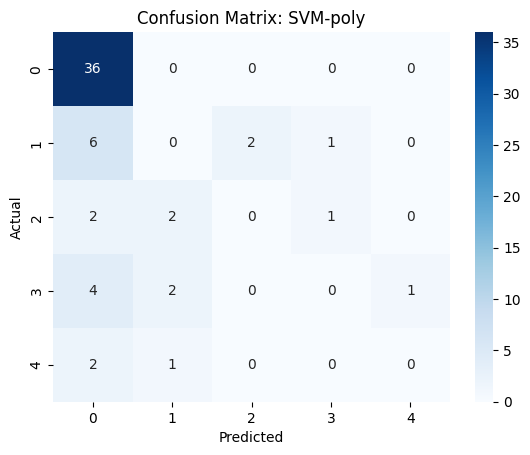

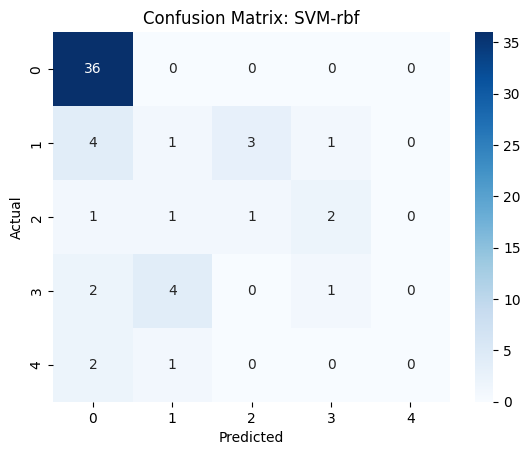

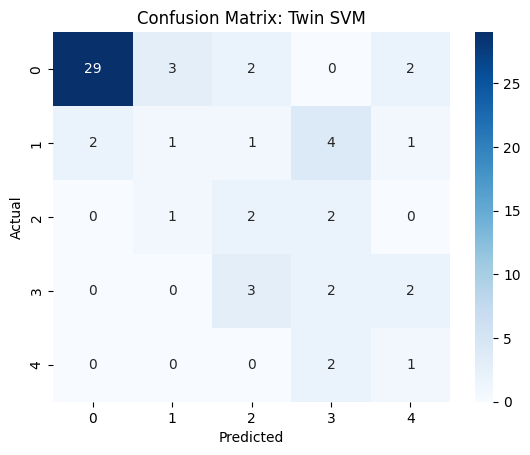

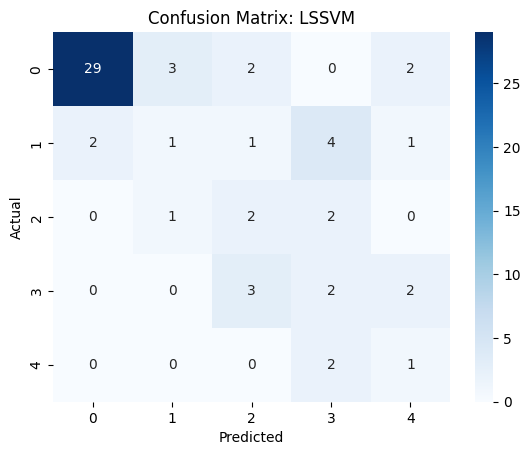

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# 🔹 Standardize the data 🔹
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Split data into training and test sets 🔹
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🔹 Function to evaluate models 🔹
def evaluate_model(model, X_train, X_test, y_train, y_test, custom=False):
    """Train and evaluate the model. If custom=True, assume it's a manual implementation like Twin SVM or LSSVM."""
    start_time = time.time()
    cpu_usage_start = psutil.cpu_percent()
    memory_usage_start = psutil.virtual_memory().used / (1024 ** 2)

    if custom:
        y_pred = model(X_train, y_train, X_test)  # Run the custom model function
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    end_time = time.time()
    cpu_usage_end = psutil.cpu_percent()
    memory_usage_end = psutil.virtual_memory().used / (1024 ** 2)

    accuracy = accuracy_score(y_test, y_pred)
    # precision = precision_score(y_test, y_pred, zero_division=0)
    # recall = recall_score(y_test, y_pred, zero_division=0)
    # f1 = f1_score(y_test, y_pred, zero_division=0)

     # 🐛 Changed 'average' to 'weighted' for multiclass precision
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    training_time = end_time - start_time
    cpu_usage = cpu_usage_end - cpu_usage_start
    memory_usage = memory_usage_end - memory_usage_start

    return accuracy, precision, recall, f1, training_time, cpu_usage, memory_usage, y_pred

# 🔹 SVM Models 🔹
svm_kernels = ['linear', 'poly', 'rbf']
svm_results = []
svm_preds = {}

for kernel in svm_kernels:
    svm = SVC(kernel=kernel, random_state=42, probability=True)
    results = evaluate_model(svm, X_train, X_test, y_train, y_test)
    svm_results.append(['SVM-' + kernel] + list(results[:-1]))
    svm_preds['SVM-' + kernel] = results[-1]

# 🔹 Twin Support Vector Machines (TWSVM) 🔹
# def twin_svm(X_train, y_train, X_test):
#     w = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
#     y_pred = np.sign(X_test @ w)
#     return (y_pred + 1) // 2  # Convert {-1,1} to {0,1}

def twin_svm(X_train, y_train, X_test):
    classes = np.unique(y_train)
    predictions = []

    for c in classes:
        # Label binarization: class c vs others
        y_bin = np.where(y_train == c, 1, -1)
        w = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_bin
        pred = X_test @ w
        predictions.append(pred)

    # Choisir la classe dont le score est le plus élevé
    predictions = np.array(predictions)
    y_pred = np.argmax(predictions, axis=0)
    return classes[y_pred]

results = evaluate_model(twin_svm, X_train, X_test, y_train, y_test, custom=True)
svm_results.append(['Twin SVM'] + list(results[:-1]))
svm_preds['Twin SVM'] = results[-1]

# 🔹 Least Squares SVM (LSSVM) 🔹
# def lssvm(X_train, y_train, X_test):
#     K = X_train @ X_train.T + np.eye(len(X_train))
#     alpha = np.linalg.solve(K, y_train)
#     y_pred = np.sign(X_test @ X_train.T @ alpha)
#     return (y_pred + 1) // 2  # Convert {-1,1} to {0,1}

def lssvm(X_train, y_train, X_test):
    classes = np.unique(y_train)
    predictions = []

    for c in classes:
        y_bin = np.where(y_train == c, 1, -1)
        K = X_train @ X_train.T + np.eye(len(X_train))
        alpha = np.linalg.solve(K, y_bin)
        pred = X_test @ X_train.T @ alpha
        predictions.append(pred)

    predictions = np.array(predictions)
    y_pred = np.argmax(predictions, axis=0)
    return classes[y_pred]

results = evaluate_model(lssvm, X_train, X_test, y_train, y_test, custom=True)
svm_results.append(['LSSVM'] + list(results[:-1]))
svm_preds['LSSVM'] = results[-1]

# 🔹 Combine results into a table 🔹
columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Training Time (s)', 'CPU Usage (%)', 'Memory Usage (MB)']
results_df = pd.DataFrame(svm_results, columns=columns)

# 🔹 Display results table 🔹
print("\nComparison of Models:")
print(results_df)

# 📊 Visualizations 📊
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparison of Model Accuracies')
plt.show()

# 📊 Visualizations 📊
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Precision', data=results_df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparison of Model Precisions')
plt.show()

# 📊 Visualizations 📊
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Recall', data=results_df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparison of Model Recalls')
plt.show()

# 📊 Visualizations 📊
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='F1-score', data=results_df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Comparison of Model F1-scores')
plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

for model, preds in {**svm_preds}.items():
    plot_confusion_matrix(y_test, preds, model)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Tabular_data/heart_disease.csv")
X_column = df.iloc[:, :-1]
feature =  X_column.columns.tolist()

print(df.shape)
print(len(feature))
print(feature)

(303, 14)
13
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


Shape de coef_ : (13,)
Longueur des features attendues : 13
Shape importance_linear : (13,)
Shape importance_rbf    : (13,)
Shape importance_poly   : (13,)
Shape importance_twin   : (13,)
Shape importance_lssvm  : (13,)


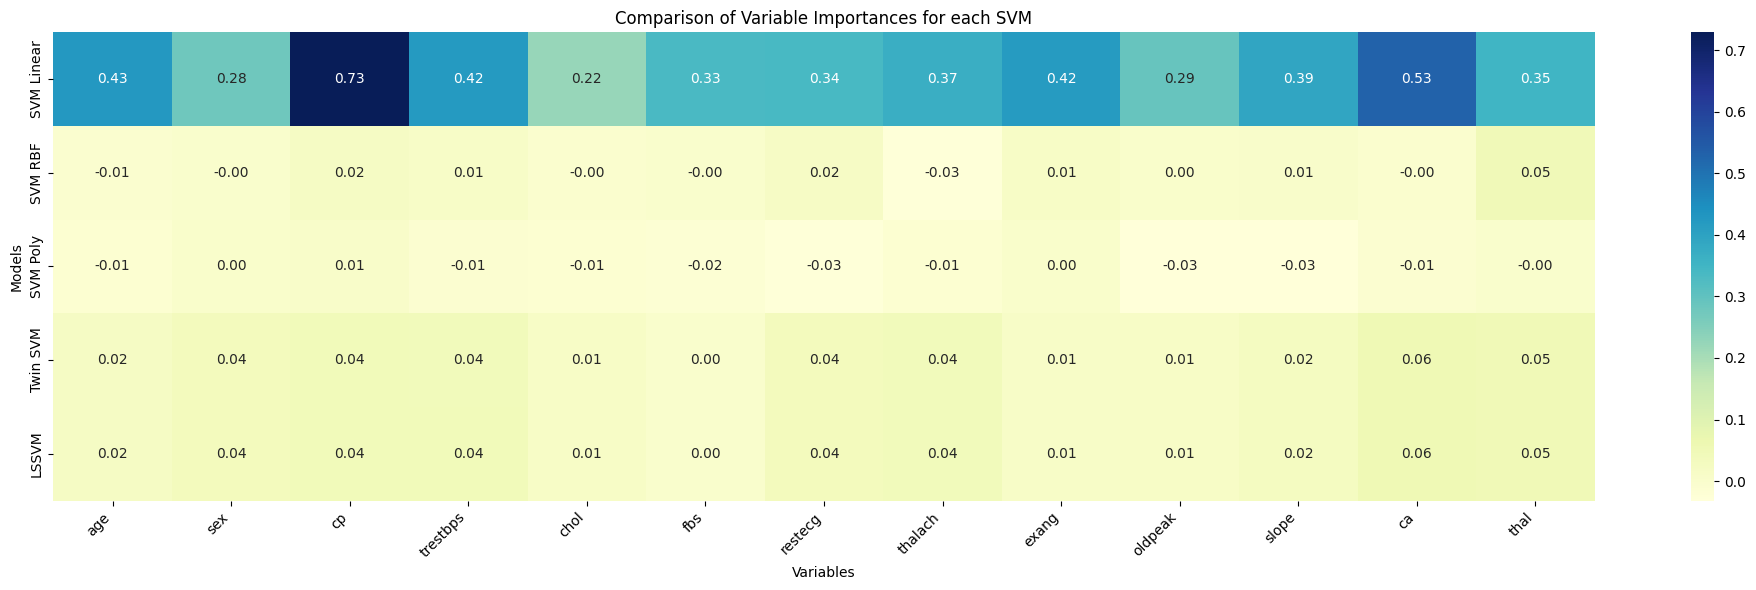

In [ ]:
from sklearn.inspection import permutation_importance


from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class TwinSVMWrapper:
    def fit(self, X, y):
        # Exemple de fitting : simple projection linéaire
        self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
        return self

    def predict(self, X):
        y_pred = np.sign(X @ self.w)
        return ((y_pred + 1) // 2).astype(int)

    def score(self, X, y):  # ← Méthode attendue par permutation_importance
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

class LSSVMWrapper(BaseEstimator):
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n = X.shape[0]
        K = X @ X.T + np.eye(n)
        self.alpha = np.linalg.solve(K, y)
        return self

    def predict(self, X):
        y_pred = np.sign(X @ self.X_train.T @ self.alpha)
        return ((y_pred + 1) // 2).astype(int)  # Convert {-1,1} to {0,1}

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)




# Linear SVM importance
svm_linear = SVC(kernel='linear', random_state=42, probability=True)
svm_linear.fit(X_train, y_train)
#importance_linear = np.abs(svm_linear.coef_).flatten()
importance_linear = np.mean(np.abs(svm_linear.coef_), axis=0)
#plot_feature_importance_heatmap(importance_linear, feature, "SVM - Linear")
print("Shape de coef_ :", importance_linear.shape)


# RBF SVM permutation importance
svm_rbf = SVC(kernel='rbf', random_state=42, probability=True)
svm_rbf.fit(X_train, y_train)
result_rbf = permutation_importance(svm_rbf, X_test, y_test, n_repeats=10, random_state=42)
importance_rbf = result_rbf.importances_mean
#plot_feature_importance_heatmap(importance_rbf, feature, "SVM - RBF")


# RBF SVM permutation importance
svm_poly = SVC(kernel='poly', random_state=42, probability=True)
svm_poly.fit(X_train, y_train)
result_poly = permutation_importance(svm_poly, X_test, y_test, n_repeats=10, random_state=42)
importance_poly = result_poly.importances_mean
#plot_feature_importance_heatmap(importance_poly, feature, "SVM - Poly")

# Twin SVM
twin_model = TwinSVMWrapper().fit(X_train, y_train)
result_twin = permutation_importance(twin_model, X_test, y_test, n_repeats=10, random_state=42)
importance_twin = result_twin.importances_mean

# LSSVM
lssvm_model = LSSVMWrapper().fit(X_train, y_train)
result_lssvm = permutation_importance(lssvm_model, X_test, y_test, n_repeats=10, random_state=42)
importance_lssvm = result_lssvm.importances_mean


print("Longueur des features attendues :", len(feature))  # Devrait être 13
print("Shape importance_linear :", importance_linear.shape)
print("Shape importance_rbf    :", importance_rbf.shape)
print("Shape importance_poly   :", importance_poly.shape)
print("Shape importance_twin   :", importance_twin.shape)
print("Shape importance_lssvm  :", importance_lssvm.shape)




# Combinaison des importances
importance_matrix2 = pd.DataFrame([
    importance_linear,
    importance_rbf,
    importance_poly,
    importance_twin,
    importance_lssvm
], index=['SVM Linear', 'SVM RBF', 'SVM Poly', 'Twin SVM', 'LSSVM'], columns=feature)

# Affichage de la heatmap comparative
plt.figure(figsize=(20, 6))
sns.heatmap(importance_matrix2, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Comparison of Variable Importances for each SVM")
plt.xlabel("Variables")
plt.ylabel("Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance_comparison_heart_disease.png') # To save the figure
plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import BaseEstimator

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

classes = np.unique(y)
print(classes)
n_classes = len(classes)

y_bin = label_binarize(y, classes=classes)

# 🔹 Split data into training and test sets 🔹
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_bin, test_size=0.2, random_state=42)


[0 1 2 3 4]


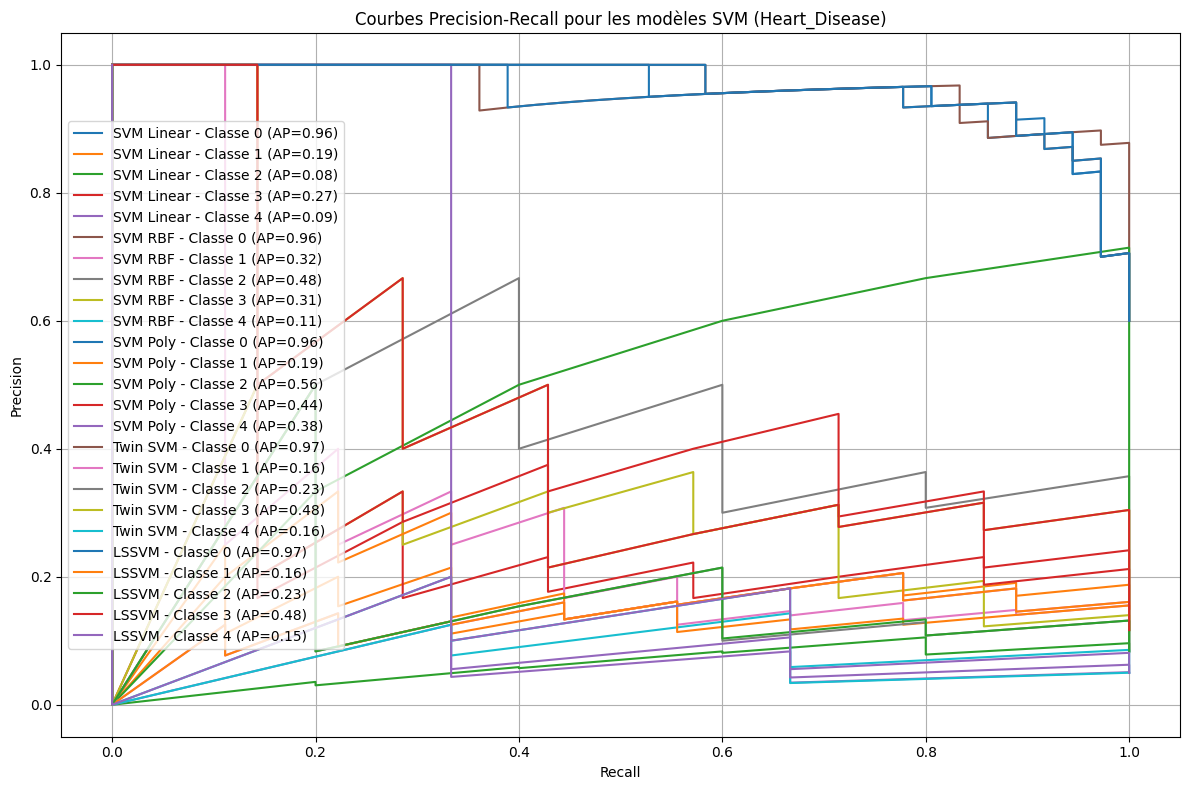

In [ ]:
# 📌 3. Définir TwinSVM et LSSVM
class TwinSVMWrapper(BaseEstimator):
    def fit(self, X, y):
        y = y * 2 - 1
        self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
        return self

    def decision_function(self, X):
        return X @ self.w

    def predict(self, X):
        return (self.decision_function(X) > 0).astype(int)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

class LSSVMWrapper(BaseEstimator):
    def fit(self, X, y):
        y = y * 2 - 1
        self.X_train = X
        K = X @ X.T + np.eye(X.shape[0])
        self.alpha = np.linalg.solve(K, y)
        return self

    def decision_function(self, X):
        return X @ self.X_train.T @ self.alpha

    def predict(self, X):
        return (self.decision_function(X) > 0).astype(int)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

# 📌 4. Liste des modèles
models = {
    "SVM Linear": OneVsRestClassifier(SVC(kernel="linear", probability=True, random_state=42)),
    "SVM RBF": OneVsRestClassifier(SVC(kernel="rbf", probability=True, random_state=42)),
    "SVM Poly": OneVsRestClassifier(SVC(kernel="poly", probability=True, random_state=42)),
    "Twin SVM": OneVsRestClassifier(TwinSVMWrapper()),
    "LSSVM": OneVsRestClassifier(LSSVMWrapper())
}

# 📌 5. Tracer les courbes PR pour chaque modèle
plt.figure(figsize=(12, 8))

for model_name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    # Pour chaque classe
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        ap = average_precision_score(y_test[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f"{model_name} - Classe {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbes Precision-Recall pour les modèles SVM (Heart_Disease)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
'''from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# 🔸 Binariser les vraies classes pour le ROC multiclass
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# for model, preds in {**svm_preds}.items():
#     fpr, tpr, _ = roc_curve(y_test, preds)
#     plt.plot(fpr, tpr, label=f"{model} (AUC: {auc(fpr, tpr):.2f})")

plt.figure(figsize=(10, 6))

# 🔸 ROC Curve pour chaque modèle qui supporte predict_proba
for model_name in ['SVM-linear', 'SVM-poly', 'SVM-rbf']:
    model = SVC(kernel=model_name.split('-')[1], probability=True, random_state=42)
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    # 🔸 ROC pour chaque classe
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} - Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()
'''

'from sklearn.preprocessing import label_binarize\nfrom sklearn.metrics import roc_curve, auc\n\n# 🔸 Binariser les vraies classes pour le ROC multiclass\ny_test_bin = label_binarize(y_test, classes=np.unique(y))\nn_classes = y_test_bin.shape[1]\n\n# for model, preds in {**svm_preds}.items():\n#     fpr, tpr, _ = roc_curve(y_test, preds)\n#     plt.plot(fpr, tpr, label=f"{model} (AUC: {auc(fpr, tpr):.2f})")\n\nplt.figure(figsize=(10, 6))\n\n# 🔸 ROC Curve pour chaque modèle qui supporte predict_proba\nfor model_name in [\'SVM-linear\', \'SVM-poly\', \'SVM-rbf\']:\n    model = SVC(kernel=model_name.split(\'-\')[1], probability=True, random_state=42)\n    model.fit(X_train, y_train)\n    y_score = model.predict_proba(X_test)\n\n    # 🔸 ROC pour chaque classe\n    for i in range(n_classes):\n        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])\n        roc_auc = auc(fpr, tpr)\n        plt.plot(fpr, tpr, label=f\'{model_name} - Class {i} (AUC = {roc_auc:.2f})\')\n\nplt.plot([0, 1

In [ ]:
def cross_validate_custom_model(model_func, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Convert labels for custom models expecting {-1, 1}
        y_train_signed = 2 * y_train - 1  # From {0, 1} to {-1, 1}

        start_time = time.time()
        cpu_usage_start = psutil.cpu_percent()
        memory_usage_start = psutil.virtual_memory().used / (1024 ** 2)

        y_pred = model_func(X_train, y_train_signed, X_test)

        end_time = time.time()
        cpu_usage_end = psutil.cpu_percent()
        memory_usage_end = psutil.virtual_memory().used / (1024 ** 2)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        train_time = end_time - start_time
        cpu = cpu_usage_end - cpu_usage_start
        mem = memory_usage_end - memory_usage_start

        metrics.append([acc, prec, rec, f1, train_time, cpu, mem])

    # Compute mean of metrics across folds
    mean_metrics = np.mean(metrics, axis=0)
    return mean_metrics

# Twin SVM CV
twin_svm_cv = cross_validate_custom_model(twin_svm, X_scaled, y)
svm_results.append(['Twin SVM (CV)'] + list(twin_svm_cv))

# LSSVM CV
lssvm_cv = cross_validate_custom_model(lssvm, X_scaled, y)
svm_results.append(['LSSVM (CV)'] + list(lssvm_cv))

labels = ["Accuracy", "Precision", "Recall", "F1-score", "Train Time (s)", "CPU Usage", "Memory Usage (MB)"]

print("🔹 Twin SVM Cross-Validation Results:")
for label, val in zip(labels, twin_svm_cv):
    print(f"{label}: {val:.4f}")

print("\n🔹 LSSVM Cross-Validation Results:")
for label, val in zip(labels, lssvm_cv):
    print(f"{label}: {val:.4f}")

🔹 Twin SVM Cross-Validation Results:
Accuracy: 0.5825
Precision: 0.4959
Recall: 0.5825
F1-score: 0.5256
Train Time (s): 0.0007
CPU Usage: -62.2000
Memory Usage (MB): 0.0000

🔹 LSSVM Cross-Validation Results:
Accuracy: 0.5825
Precision: 0.4959
Recall: 0.5825
F1-score: 0.5256
Train Time (s): 0.0021
CPU Usage: -50.0000
Memory Usage (MB): 0.0000


In [ ]:
# Cross-Validation
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("value of cv:", cv)

for kernel in svm_kernels:
  model_SVM = SVC(kernel=kernel, random_state=42, probability=True)

  grid = GridSearchCV(model_SVM, param_grid, cv=5)
  grid.fit(X_train, y_train)

  print("Best parameters:", grid.best_params_)
  print("Best score:", grid.best_score_)
  print("Best estimation:", grid.best_estimator_)

  # Evaluaion
  test_score = grid.score(X_test, y_test)
  print("Test accuracy:", test_score)

  scores_grid = cross_val_score(grid.best_estimator_, X_train, y_train, cv=5)
  print("Mean Score:", scores_grid.mean())

  scores = cross_val_score(model_SVM, X_train, y_train, cv=cv) # With 5 fold
  print(f"Cross-validation scores for {kernel} kernel: {scores.mean()}")
  print("--------------------------------------------------------------")

value of cv: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


ValueError: 
All the 90 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 197, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1387, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1408, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1485, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (189, 5) instead.

--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 197, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1387, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1408, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1485, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (190, 5) instead.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import shapiro, ttest_rel, wilcoxon
import numpy as np
from numpy.linalg import inv, norm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from qpsolvers import solve_qp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


# 🔹 Standardize the data 🔹
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Define models 🔹
svm_kernels = ['linear', 'poly', 'rbf']
svm_models = [SVC(kernel=k, probability=True, random_state=42) for k in svm_kernels]


# 🔹 Cross-validation 🔹
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = {name: [] for name in ['SVM-linear', 'SVM-poly', 'SVM-rbf']}

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx] # Use scaled data
    y_train, y_test = y[train_idx], y[test_idx]

    for kernel, model in zip(svm_kernels, svm_models):
        # SVM models (SVC) handle {0, 1} labels directly
        # Reset the model for each fold to avoid retaining training state
        model = SVC(kernel=kernel, probability=True, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        f1 = f1_score(y_test, preds, average='weighted', zero_division=0)
        f1_scores[f'SVM-{kernel}'].append(f1)
        print(f"  SVM-{kernel} F1: {f1:.4f}")

# 🔹 Normality test (Shapiro) on differences 🔹
# Ensure both lists have the same number of elements before computing diff
if len(f1_scores['SVM-rbf']) == len(f1_scores['SVM-linear']):
    diff = np.array(f1_scores['SVM-rbf']) - np.array(f1_scores['SVM-linear'])
    # Shapiro test requires at least 3 samples.
    if len(diff) >= 3:
        try:
            shapiro_test = shapiro(diff)
            print("\nShapiro-Wilk Test:", shapiro_test)
            stat, p_value = shapiro_test
            print(f"Shapiro Statistic = {stat:.4f}, p-value = {p_value:.4f}")
            if p_value > 0.05:
                print("✅ Les différences suivent une loi normale (on peut utiliser le t-test).")
            else:
                print("❌ Les différences ne suivent pas une loi normale (préférer le test de Wilcoxon).")
        except ValueError as e:
             print(f"\nSkipping Shapiro-Wilk Test: {e}")
             shapiro_test = "N/A"
    else:
        print("\nSkipping Shapiro-Wilk Test: Need at least 3 folds.")
        shapiro_test = "N/A"

else:
    print("\nSkipping Shapiro-Wilk Test due to unequal number of folds.")
    shapiro_test = "N/A"


# 🔹 Paired t-test and Wilcoxon test 🔹
# Ensure both lists have the same number of elements before computing t-test/wilcoxon
if len(f1_scores['SVM-rbf']) == len(f1_scores['SVM-linear']):
    # Need at least 2 folds for t-test/wilcoxon
    if len(f1_scores['SVM-rbf']) >= 2:
        try:
            # Paired t-test assumes normal distribution of differences
            t_test = ttest_rel(f1_scores['SVM-rbf'], f1_scores['SVM-linear'])
            print("\nPaired t-test:", t_test)
            t_stat, p_value = t_test

            print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
            if p_value < 0.05:
                print("Différence significative entre les modèles.")
            else:
                print("Pas de différence significative.")
        except ValueError as e:
             print(f"\nSkipping Paired t-test: {e}")
             t_test = "N/A"

        try:
            # Wilcoxon signed-rank test is a non-parametric alternative
            wilcoxon_test = wilcoxon(f1_scores['SVM-rbf'], f1_scores['SVM-linear'])
            print("\nWilcoxon test:", wilcoxon_test)
            stat, p = wilcoxon_test

            print(f"Wilcoxon statistic = {stat:.4f}, p-value = {p:.4f}")
            if p < 0.05:
                print("Différence significative entre les modèles.")
            else:
                print("Pas de différence significative.")
        except ValueError as e:
             print(f"\nSkipping Wilcoxon test: {e}")
             wilcoxon_test = "N/A"

    else:
        print("\nSkipping t-test and Wilcoxon test: Need at least 2 folds.")
        t_test = "N/A"
        wilcoxon_test = "N/A"

else:
    print("\nSkipping t-test and Wilcoxon test due to unequal number of folds.")
    t_test = "N/A"
    wilcoxon_test = "N/A"


# 🔹 Results 🔹
print("\nF1-scores:", f1_scores)
# Shapiro test, t-test, and Wilcoxon test results are printed above